# **HUGE** Thanks to Google Colab for making this code work

In [0]:
'''
    classifying MNIST using an AUTOENCODER CNN on Tensorflow
    Dataset: MNIST
    Author: Aashish Kumar Sahu
    Blog: aashishksahu.wordpress.com
'''
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# creating minibatches
def mini_batch(X, size):
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, 28, 28, 1)
    
    return x_bat

In [0]:
import random
# this function adds noise to the images
def create_noise(image):
    x = np.arange(1)
    noise = 0.0008*np.asarray(random.sample(range(0,1000),1))
    return image + noise

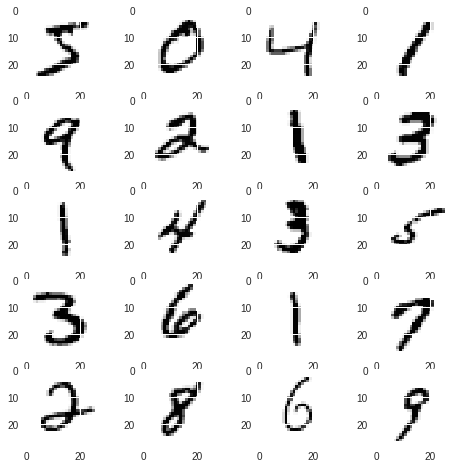

In [121]:
# importing mnist dataset from keras
mnist = tf.keras.datasets.mnist
(x_train,y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
# plotting reconstructed images
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[j])
    j+=1
    
plt.show()

In [122]:
x_train = x_train.reshape(len(x_train),  28,  28,  1).astype(np.float32)
x_test = x_test.reshape(len(x_test),  28,  28,  1).astype(np.float32)
print("training data: ", x_train.shape)
print("testing data : ", x_test.shape)

training data:  (60000, 28, 28, 1)
testing data :  (10000, 28, 28, 1)


In [0]:
tf.reset_default_graph()
# creating placeholder for input image data
inputs = tf.placeholder(tf.float32, (None, 28,28,1))
target = tf.placeholder(tf.float32, (None, 28,28,1))

# kernel weights
wc1 = tf.get_variable('wc1', [3,3,1,32], initializer=tf.contrib.layers.xavier_initializer())
wc2 = tf.get_variable('wc2', [3,3,32,32], initializer=tf.contrib.layers.xavier_initializer())
wc3 = tf.get_variable('wc3', [3,3,32,32], initializer=tf.contrib.layers.xavier_initializer())
wc4 = tf.get_variable('wc4', [3,3,32,16], initializer=tf.contrib.layers.xavier_initializer())
wc5 = tf.get_variable('wc5', [3,3,16,32], initializer=tf.contrib.layers.xavier_initializer())
wc6 = tf.get_variable('wc6', [3,3,32,32], initializer=tf.contrib.layers.xavier_initializer())
wc7 = tf.get_variable('wc7', [3,3,32,1], initializer=tf.contrib.layers.xavier_initializer())

In [124]:
# learning rate
learning_rate = 0.001

with tf.device('/gpu:0'):
    # encoder unit
    c1 = tf.nn.tanh(tf.nn.conv2d(inputs, wc1, strides = [1,1,1,1], padding = 'SAME'))
    m1 = tf.nn.max_pool(c1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # m1 shape = 14 x 14 x 32
    print('m1     :',m1.shape)
    c2 = tf.nn.tanh(tf.nn.conv2d(m1, wc2, strides = [1,1,1,1], padding = 'SAME'))
    m2 = tf.nn.max_pool(c2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # m2 shape = 7 x 7 x 32
    print('m2     :',m2.shape)
    c3 = tf.nn.tanh(tf.nn.conv2d(m2, wc3, strides = [1,1,1,1], padding = 'SAME'))
    encoded = tf.nn.max_pool(c3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # encoded shape = 4 x 4 x 32
    print('encoder:',encoded.shape)

    # decoder unit
    d1 = tf.image.resize_images(encoded, size = (7,7), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    c4 = tf.nn.tanh(tf.nn.conv2d(d1, wc4, strides = [1,1,1,1], padding = 'SAME'))
    print('c4     :', c4.shape)
    d2 = tf.image.resize_images(c4, size = (14,14), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    c5 = tf.nn.tanh(tf.nn.conv2d(d2, wc5, strides = [1,1,1,1], padding = 'SAME'))
    print('c5     :', c5.shape)
    d3 = tf.image.resize_images(c5, size = (28,28), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    c6 = tf.nn.tanh(tf.nn.conv2d(d3, wc6, strides = [1,1,1,1], padding = 'SAME'))
    print('c6     :', c6.shape)
    logits = tf.nn.conv2d(c6, wc7, strides = [1,1,1,1], padding = 'SAME')
    print('logits :',logits.shape)
    # sigmoid cross entropy
    cost_func = tf.reduce_mean(tf.squared_difference(inputs, logits))
    optimize = tf.train.AdamOptimizer(learning_rate).minimize(cost_func)

m1     : (?, 14, 14, 32)
m2     : (?, 7, 7, 32)
encoder: (?, 4, 4, 32)
c4     : (?, 7, 7, 16)
c5     : (?, 14, 14, 32)
c6     : (?, 28, 28, 32)
logits : (?, 28, 28, 1)


In [0]:
# creating a tensorflow session
s = tf.Session(config=tf.ConfigProto(log_device_placement=True))
s.run(tf.global_variables_initializer())


epochs = 2000

Initiating Training Sequence...
Training complete...


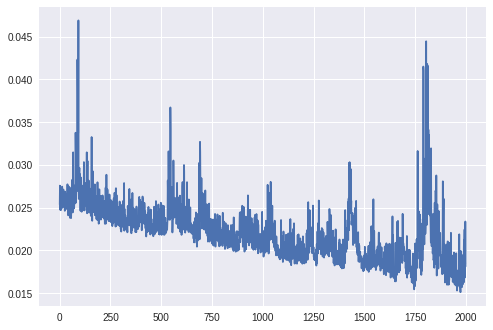

In [127]:
cost = []
# training loop
print("Initiating Training Sequence...")
for i in range(epochs):
    train_batch = mini_batch(x_train, 512)
    noise_batch = create_noise(train_batch)
    s.run(optimize, {inputs : noise_batch, target : train_batch})  
    cost.append(np.average(s.run(cost_func, {inputs:noise_batch, target: train_batch})))

print("Training complete...")
plt.plot(range(0, epochs), cost)
plt.show()

test set loss:  0.020627247


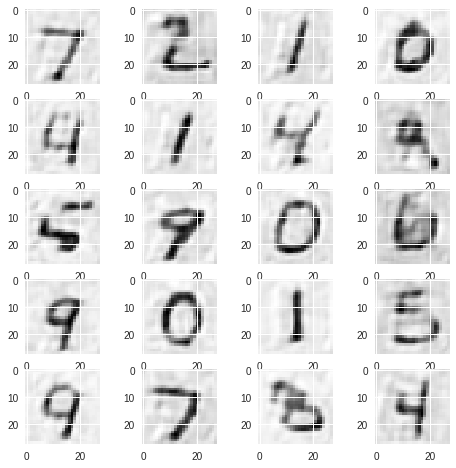

In [128]:
# prediction and accuracy

# creating noise image from test set
noise_test = np.array(create_noise(x_test))
# images generated on new data
prediction = s.run(logits, {inputs: x_test, target: noise_test})
cost_test = np.average(s.run(cost_func, {inputs:create_noise(x_test), target: x_test}))
print("test set loss: ",cost_test)

prediction = prediction.reshape(len(prediction), 28, 28)

# plotting reconstructed images
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(prediction[j])
    j+=1
    
plt.show()